## Datasets that are as clean as possible



### Test data - Amphimedon and Nematostella  

I'm going to use a sponge and a cnido to start with because they are the kinds of organisms I want this program to be useful for (and also they are cool). They also have decent(?) genomes, or at least well-used ones, so maybe they can help me get an idea of how "clean" I can get an assembly to be.  

I'll downloaded a dataset for each one from the ENA. The Amphimedon is JADHEG01 and the Nematostella is ABAV01.  

### Kraken  

I've never used kraken (or kraken2 at this point) before, so this is kind of a slow process. I found the documentation (https://github.com/DerrickWood/kraken2/wiki/Manual#special-databases)(which seems to be organized in a non-intuitive way, so that's fun) and I think it has at least most of what I need. Hopefully I can get the rest from the help page and this tutorial I found: https://bioinformaticsworkbook.org/dataAnalysis/Metagenomics/Kraken.html#gsc.tab=0.  

I looked at a kraken job that Rebecca submitted (presumably sometime in the last six months) and tried to copy some of her settings whenever possible. She used a database that was already downloaded, and I think it is just the standard kraken one, so I'm going to try to use that too. If I get an error that it is not available, I'll figure out what to do next. The settings and command I tried are below.  

- CPU time: short  
- Memory: 8Gb  
- Type of PE: multi-thread  
- Number of CPUs: 12  
- Job name: amph_kraken

`kraken2 --db /data/genomics/db/Kraken/kraken2_db/ --unclassified-out amph_unclassified --report amph_report_kraken --threads $NSLOTS  Amphimedon.fasta`  

After I saved it to my computer and transferred it onto Hydra, I changed the module that it connects to. The only one you can access in the QSub Generation Utility is the oldest installation, so I just added the version directory in the module load part manually.

Ok, I finally got this running, and updated the kraken script above to reflect the one that functions.  

I also separated the std error, because I think it prints a lot of results there (since there does not seem to be a way to specify a main output file), and because it didn't seem to be able to find my input files when I used > to try to capture it in a different file.  

After I got results back I ran it on the Nematostella genome also.

### Kraken output  

**Amphimedon**  
1422 sequences classified (36.73%)  
2449 sequences unclassified (63.27%)  

**Nematostella**  
15862 sequences classified (26.82%)  
43287 sequences unclassified (73.18%)  

Since the database contains just viruses, bacteria, and human sequences, it is good that lots of sequences are unclassified. Also, probably lots of the human ones are misclassified, and if you were dealing with a more specific database, many of them would likely hit closer to the mark. 

### Investigating kmers  

In the log file (where kraken dumps all the actual results), you can get the specific info for each contig (or sequence, or whatever you put in it). The first letter just stands for classified or unclassified, then they give the name of the sequence/contig, then what category it was assigned to (unclassified, human, bacteria species, etc.) with its taxon id, the length of the sequence/contig, and then how it got divided up in terms of kmers.  

For example, `C	ENA|ABAV01000001|ABAV01000001.1	Homo sapiens (taxid 9606)	20022	0:3438 9606:8 0:16542` this is saying that there were 3438 kmers that did not have a match in the database, 8 kmers that matched human (9606), and then 16542 kmers that didn't have a match again. Somehow, this is still being classified as a human, which is pretty wild. Just anecdotally, looking through this, lots of the ones classified as humans look like this. I don't really understand if there is a threshold or something, because others remain unclassified even when kraken finds some kmers that match human sequences. Like this one: `U	ENA|ABAV01000008|ABAV01000008.1	unclassified (taxid 0)	4802	0:508 9606:5 0:4255`. It has five kmers that match a human, but it is unclassified while the above one is not, even though it's really a higher percentage of the whole sequence.  

I decided to sequester all of the contigs that were classified as bacterial and viral in their own file.  

`grep -v "unclassified\|Homo sapiens" nema_kraken.log > nema_contaminants.tsv`  

So I can look at these in isolation if I decide.  

In [1]:
import pandas as pd

In [11]:
nema = pd.read_csv("nema_kraken.log")

In [12]:
nema.head()

,class_unclass,contig_name,taxon,length,kmers
0,C,ENA_ABAV01000001_ABAV01000001.1,Homo sapiens (taxid 9606),20022.0,0:3438 9606:8 0:16542
1,U,ENA_ABAV01000002_ABAV01000002.1,unclassified (taxid 0),10536.0,0:10502
2,U,ENA_ABAV01000003_ABAV01000003.1,unclassified (taxid 0),904.0,0:870
3,U,ENA_ABAV01000004_ABAV01000004.1,unclassified (taxid 0),4548.0,0:4514
4,C,ENA_ABAV01000005_ABAV01000005.1,Homo sapiens (taxid 9606),49951.0,0:11978 9606:2 0:1452 9606:1 0:902 9606:5 0:84...


In [16]:
nema[nema.length <= 5000].head()

,class_unclass,contig_name,taxon,length,kmers
2,U,ENA_ABAV01000003_ABAV01000003.1,unclassified (taxid 0),904.0,0:870
3,U,ENA_ABAV01000004_ABAV01000004.1,unclassified (taxid 0),4548.0,0:4514
6,U,ENA_ABAV01000007_ABAV01000007.1,unclassified (taxid 0),2191.0,0:2157
7,U,ENA_ABAV01000008_ABAV01000008.1,unclassified (taxid 0),4802.0,0:508 9606:5 0:4255
9,U,ENA_ABAV01000010_ABAV01000010.1,unclassified (taxid 0),972.0,0:938


This is showing me the contigs that are below a certain length, but I'm going to try sorting them, so I can see all the ones that are small.  

In [38]:
sorted_nema = nema.sort_values(by = ["length"])
sorted_nema.head(n = 20)

,class_unclass,contig_name,taxon,length,kmers
9471,U,ENA_ABAV01009472_ABAV01009472.1,unclassified (taxid 0),12.0,0:0
9469,U,ENA_ABAV01009470_ABAV01009470.1,unclassified (taxid 0),18.0,0:0
9468,U,ENA_ABAV01009469_ABAV01009469.1,unclassified (taxid 0),21.0,0:0
9472,U,ENA_ABAV01009473_ABAV01009473.1,unclassified (taxid 0),28.0,0:0
9475,U,ENA_ABAV01009476_ABAV01009476.1,unclassified (taxid 0),29.0,0:0
9478,U,ENA_ABAV01009479_ABAV01009479.1,unclassified (taxid 0),30.0,0:0
9466,U,ENA_ABAV01009467_ABAV01009467.1,unclassified (taxid 0),30.0,0:0
9465,U,ENA_ABAV01009466_ABAV01009466.1,unclassified (taxid 0),30.0,0:0
9470,U,ENA_ABAV01009471_ABAV01009471.1,unclassified (taxid 0),31.0,0:0
9463,U,ENA_ABAV01009464_ABAV01009464.1,unclassified (taxid 0),32.0,0:0


In [35]:
sorted_nema.iloc[200:205]

,class_unclass,contig_name,taxon,length,kmers
48053,U,ENA_ABAV01048054_ABAV01048054.1,unclassified (taxid 0),404.0,0:370
55835,U,ENA_ABAV01055836_ABAV01055836.1,unclassified (taxid 0),404.0,0:370
41353,U,ENA_ABAV01041354_ABAV01041354.1,unclassified (taxid 0),404.0,0:370
18732,U,ENA_ABAV01018733_ABAV01018733.1,unclassified (taxid 0),404.0,0:370
52029,C,ENA_ABAV01052030_ABAV01052030.1,Homo sapiens (taxid 9606),405.0,0:313 9606:4 0:1 9606:5 0:48


The smallest contigs look like they are either unclassified or barely getting classified as human. I want to check out the bacteria and virus contigs specifically. I used the same grep line as above that I previously used on Hydra, but on the slightly modified csv I made of the nematostella log file above.

In [37]:
micros = pd.read_csv("nema_micros.csv")
micros.head()

,class_unclass,contig_name,taxon,length,kmers
0,C,ENA_ABAV01000148_ABAV01000148.1,Pandoraea oxalativorans (taxid 573737),12303.0,0:290 573737:1 0:994 9606:4 0:112 9606:4 13156...
1,C,ENA_ABAV01000310_ABAV01000310.1,cellular organisms (taxid 131567),10228.0,A:1 0:1669 9606:2 0:401 386415:2 0:8119
2,C,ENA_ABAV01000479_ABAV01000479.1,Streptomyces sp. TLI_053 (taxid 1855352),23069.0,0:721 1855352:5 0:155 1855352:5 0:27 1855352:5...
3,C,ENA_ABAV01000507_ABAV01000507.1,Streptococcus dysgalactiae subsp. equisimilis ...,3767.0,0:773 119602:5 0:1609 9606:4 0:1342
4,C,ENA_ABAV01000535_ABAV01000535.1,Rhodobacteraceae bacterium (taxid 1904441),22606.0,0:5819 1261031:2 0:10583 1904441:5 0:6163


In [41]:
sorted_micros = micros.sort_values(by = ["length"])
sorted_micros.head(n = 20)

,class_unclass,contig_name,taxon,length,kmers
355,C,ENA_ABAV01015544_ABAV01015544.1,other sequences (taxid 28384),280.0,28384:25 1:158 0:3 1:5 0:55
1442,C,ENA_ABAV01048353_ABAV01048353.1,Pseudomonas sp. CC6-YY-74 (taxid 1930532),444.0,0:66 135621:12 1534110:5 286:3 1534110:3 0:62 ...
632,C,ENA_ABAV01023546_ABAV01023546.1,Clostridium botulinum (taxid 1491),461.0,0:22 526969:5 131567:49 0:10 131567:1 0:29 131...
1250,C,ENA_ABAV01043368_ABAV01043368.1,Clostridium baratii str. Sullivan (taxid 1415775),521.0,0:103 262:1 0:30 1415775:2 0:351
1866,C,ENA_ABAV01056593_ABAV01056593.1,Actinoalloteichus sp. AHMU CJ021 (taxid 2072503),537.0,0:342 2072503:5 2:5 2072503:2 2:5 2072503:2 2:...
1329,C,ENA_ABAV01045675_ABAV01045675.1,Tenacibaculum todarodis (taxid 1850252),546.0,0:191 1850252:4 0:8 1312072:2 0:14 1850252:15 ...
1632,C,ENA_ABAV01051907_ABAV01051907.1,Clostridium botulinum (taxid 1491),550.0,0:11 1491:5 0:64 9606:4 0:69 1491:5 0:3 1491:2...
130,C,ENA_ABAV01005445_ABAV01005445.1,other sequences (taxid 28384),574.0,28384:29 1:3 0:508
1862,C,ENA_ABAV01056569_ABAV01056569.1,Clostridium botulinum (taxid 1491),589.0,0:303 1491:4 131567:3 0:5 1491:3 0:35 2057025:...
1863,C,ENA_ABAV01056570_ABAV01056570.1,Bacillus cereus m1293 (taxid 526973),599.0,0:53 A:34 9606:2 0:45 9606:7 0:4 9606:17 0:22 ...


In [43]:
sorted_micros.tail()

,class_unclass,contig_name,taxon,length,kmers
62,C,ENA_ABAV01002553_ABAV01002553.1,Proteobacteria (taxid 1224),63096.0,0:17121 1620215:1 0:4106 1002804:1 0:41833
264,C,ENA_ABAV01012069_ABAV01012069.1,Burkholderiales (taxid 80840),77005.0,0:2551 9606:6 0:4881 9606:4 0:10216 9606:45 0:...
112,C,ENA_ABAV01004701_ABAV01004701.1,Edwardsiella (taxid 635),79998.0,0:1716 9606:2 0:1973 9606:1 0:30 131567:2 0:94...
323,C,ENA_ABAV01014257_ABAV01014257.1,Edwardsiella (taxid 635),108723.0,0:12075 9606:10 0:1626 9606:2 0:2 9606:5 0:206...
2119,= Thu Aug 26 10:44:19 EDT 2021 job nema_kraken...,NaN,NaN,NaN,NaN


It looks like kraken is classifying these contigs based on a very small number of kmers in many if not all cases. This might be because it's really designed to work with reads (Illumina ones) not with longer sequences that come from long read tech or assembly. So I think my next move (after the new, correct database is up and running) is to map the reads for these assemblies onto the assembled contigs, and run kraken on all the reads that map. Then I'll be able to compare that output to this (redone with the same database) to see how comparable they are. Could be that a read would get classified really well, but it looks ridiculous in the middle of a hugh contig. Definitely some contaminating reads could have made it into the assembly itself, so it would be good to know how they behave.

## Mapping reads to assemblies  

Because kraken seems like it might do better with reads instead of contigs, I'm going to take the reads that were used to make the assemblies, map them onto the assembly, and run kraken on those so that I can compare the results to the ones I already have for these test organisms.  

First up: mapping.  

I'm going to use a dataset I found for *Actinia tenebrosa* for this part, just because it was the first genome I found where I could also find the exact reads used to assembly the genome. I might write more on this below, but for now, let's push on. Project accession is this: PRJNA505921.    

I ran kraken on this genome also, exactly the same way I did before. All of it's files have "acti" at the beginning instead of the other prefixes. I'll probably do a more full name when I redo the work for the whole dataset, but this works for now.  

I'm going to use BWA for the mapping, because it does well in comparisons and because I already have code that I've used to run it. I'm keeping my memory and CPUs the same as I did for kraken, and will adjust if necessary.  

First I need to build an index. Script is called "bwa_acti_index.job" and the important bit is below.  
`bwa index -p acti_index Actinia.fasta`  

Seems like it worked, and happened very quickly!

Next up: the actual mapping.  

Now that I have the assembly indexed, I can map reads onto it. Again, I'm keeping the same script settings for now, and I can change them if it runs out of memory or something. I'd rather start with less than I need than take up resources I don't end up using.  

"bwa_acti_map.job"  
`bwa mem -t $NSLOTS acti_index reads/Actinia_tenebrosa_1.fastq reads/Actinia_tenebrosa_2.fastq > acti_mapped.sam`  

"acti_samtools.job"  
`samtools view -bu -@ $NSLOTS acti_mapped.sam | samtools sort -T acti -O bam -@ $NSLOTS -l 9 -m 2G -o acti_mapped.sorted.bam`  

I split them up because it was easier to troubleshoot. Mapping seemed to work fine.  


Now I need to pull the mapped reads from all the rest of the reads. I'm not totally confident I needed to do the previous samtools steps. I thought it would be safe to do the converting and sorting, as I would need to do those steps no matter what, but that doesn't really seem to be the case. I've made a new script now (same basic parameters as before) that does the two steps I'm pretty sure I need to do.  

"acti_filter.job"  
`samtools view -b -F 4 -@ $NSLOTS -o acti_mapped_reads.bam acti_mapped.sam`  
`samtools fasta -1 acti_mapped_reads_1.fasta -2 acti_mapped_reads_2.fasta -@ $NSLOTS -n acti_mapped_reads.bam`  

I also want to know more about how things mapped, so I'm running a stats program and a depth one so I can have a clearer idea. Same parameters as before, as they have been working out, and don't take forever to start or anything.  

"acti_mapstats.job"  
`samtools flagstat -@ $NSLOTS acti_mapped.sam > acti_mapstats.txt`  
`samtools depth -@ $NSLOTS -H -a -o acti_depth.txt acti_mapped.sam`  

I now have two read fasta files called "acti_mapped_reads_1.fasta" and "acti_mapped_reads_2.fasta" that the last samtools command gave. These I can load into a new kraken run with the same parameters as the previous kraken jobs.   
  
"acti_reads_kraken.job" And all of the output files start with "acti_reads"  
`kraken2 --db /data/genomics/db/Kraken/kraken2_db/ --unclassified-out acti_reads_unclassified# --use-names --report acti_reads_report_kraken --threads $NSLOTS --paired acti_mapped_reads_1.fasta acti_mapped_reads_2.fasta`  
The "#" symbol in the unclassified output file name is important when you have paired reads because it tells kraken to make two files with different endings - one for forward and one for reverse reads.  
  
#### Kraken reads results  

It seems like this run left a lot more things unclassified. 95.72% of things are unclassified in this run. Honestly, this makes sense, because the standard kraken database is not really built to classify these marine inverts. In the previous results, it was classifying things based on a tiny subset of kmers in the long contigs, and I couldn't understand why it would classify contigs based on so little evidence. But I think in a lot of cases, it's not doing that as much. It is still making some dodgy classifications though.   

Below, it decided in the second line that that read belonged to taxid 526973, when only two kmers matched to it. Four matched to 1239 and five matched to 131567, but for some reason it still went with Bacillius cereus.  

    U       SRR8241370.21   unclassified (taxid 0)  100|100 0:66 |:| 0:66  
    C       SRR8241370.22   Bacillus cereus m1293 (taxid 526973)    100|100 0:66 |:| 0:48 131567:5 0:2 1239:4 0:5 526973:2  

## Blobtools  

Now I want to run another decontamination program on the same dataset (still playing with Actinia) to see how it does things differently.  

The blobtools documentation looks really good and has yet to prove super helpful (I'm shocked, I tell you, SHOCKED) but exists here: https://blobtools.readme.io/docs/my-first-blobplot. It tells me that I need to use "blobtools create" to make a blobtools DB, which seems to make sense. To do this, I need a blast output file (or some other file of "hits" but blast seems like it will be the most straightforward). So first I'm running blast on my Actinia genome. I did it basically like I do most blasts, but since blobtools needs the first three collumns to be specific bits of info, I reordered the output file from what I normally do. I increased the amount of time from "short" to "medium" for this job, as I know how notoriously slow blast is, but I think it would have been okay to use the shorter time still. All other options were left the same as my usual ones.  

"acti_blast.job"  
`blastn -db nt -query genomes/Actinia.fasta -outfmt '6 qseqid sseqid evalue pident qlen length' -evalue 1e-10 -num_threads $NSLOTS -out acti_blast.out`  

Now I should be able to do the "blobtools create" command. However, my first attempts at this were straight up failures, despite looking exactly like their sample script: `blobtools create -i genomes/Actinia.fasta -b acti_mapped.bam -t acti_blast.out -o acti_blobplot`. Worse, all it is telling me is the usage for "blobtools add" which makes me think that this is more complex than I was led to believe.  

Did more googling and found this: https://blobtoolkit.genomehubs.org/blobtools2/blobtools2-tutorials/getting-started-with-blobtools2/. Looks like they do the "blobtools create" in a super minimal way first, and then do the "blobtools add" to do all the rest of the stuff. I'm going to split them up so if the first errors, I can see it better.  

"acti_blob_create.job"  
`blobtools create --fasta genomes/Actinia.fasta acti_blobplot`  

Ok, it certainly did something. The log file (acti_blob_create.log) has a bunch of evidence of things happening, and no tracebacks. It also made the directory "acti_blobplot" like it was supposed to, and there are .json files in there, which seems promising.  

Now I'm going to try to do the "add" thing with the blast output and the bam file: `blobtools add --threads $NSLOTS --hits acti_blast.out --cov acti_mapped_reads.bam acti_blobplot`. Sadly, did not work. Lots of tracebacks. It seems to be saying that it couldn't create an index for my bam file, but I already have one, so can I just give them that instead? Doesn't seem like it. The example gives a sorted bam file, so I'll try that next with my "acti_mapped.sorted.bam".  

Now it seems like the bam file part worked, but not the hits file part. I'm going to delete what I already have and remake it from the create command (which takes two seconds) and then run the add command with just the bam file to make sure. Then I can try to figure out why the hits file isn't working.  

"acti_blob_add.job" (with "acti_blob_add_bam.log as the log file)  
`blobtools add --threads $NSLOTS --cov acti_mapped.sorted.bam acti_blobplot`  

Running it and just adding the bam file worked great, so now hopefully I can figure out what is going wrong with the hits file. I'll just use the same script as above, but comment out the bam line, add another for the hits, and change the log file name to "acti_blob_add_hits.log".  

Before I ran the lastest attempt, I found more info on adding the hits here: https://blobtoolkit.genomehubs.org/blobtools2/blobtools2-tutorials/adding-data-to-a-dataset/adding-hits/. And this site lists "--taxdump" as a required option. Which would have been good to know, but makes sense, as this was what the error message was whining about. I could download the NCBI taxdump files from here: https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/, and there is info on how to do it here: https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdump_readme.txt. So now I have those files and unzipped them and they live in this directory: /scratch/genomics/spillanej/contamination/decon_test/ncbi_taxdump. Now I can point that required flag to this directory and see how things go. `blobtools add --threads $NSLOTS --hits acti_blast.out --taxdump ncbi_taxdump/ acti_blobplot`

Ok, that didn't work. There seems to be a problem with "load_ancestors" when it parses the taxdump. Did I grab the wrong thing?  

Ugh, it looks like there is just more. According to this site https://blobtoolkit.genomehubs.org/install/#databases, I actually need three different databases to make this work. Annoying. And I'm not really sure how I'm supposed to point to where these three databases live, since the only option that seems to do this is the --taxdump flag, but that is pretty specific and doesn't seem like it is supposed to have multiple arguments. Also, the example that they give in the "adding hits" section (linked above) only has the taxdump database, and does not seem to use any others. So I'm not sure where I'm going wrong. 

OK! Progress! I do not need those other databases for this step, I think they are just for other (earlier?) steps of this pipeline. The only one I need for this is the taxdump, and you really really have to download it from here: https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/new_taxdump.tar.gz because no other version will work. Kevin Kocot actually raised this as an issue and that was the answer he got, so shout out to Kevin for making the same mistake as me like three months ago. If you just do it exactly as they say here https://blobtoolkit.genomehubs.org/install/#databases it will work.  

That is, until the next error.  

I'm a little bit wondering if there is an underlying problem with my blast output. I think I'm going to rerun that with exactly the settings they have in the blobtools example so that I can try to rule that out as a factor. I'm honestly not sure I did it right in any case.      

New "acti_blast.job"  
`blastn -db /data/genomics/db/ncbi/db/latest_v4/nt/nt -query genomes/Actinia.fasta -outfmt "6 qseqid staxids bitscore std" -max_target_seqs 10 -max_hsps 1 -evalue 1e-20 -num_threads $NSLOTS -out acti_blast.out`  

Sadly, although the blast job finished just fine and gave me results that look normal, when I tried rerunning the command to add the hits, it still errored with the same message. Back to the googles.  

I think I found it! Finially must have searched for the right keywords. Apparently there was an issue in the version 2.6.1 that I've been using, and just recently they came out with 2.6.2 in which this issue is fixed. So a quick update should solve it. I've sent the install links to Rebecca, just waiting for word back.  

Updated! I can load the newest version with `module load bio/blobtools/2.6.3`, so I have updated the script to reflect that and submitted!  And now, after a full update, and then another update of the "tolkein" module that it needs, I think it finally worked!  

"acti_blob_add.job" (with "acti_blob_add_hits.log" as the log file, and the previous command commented out)  
`blobtools add --threads $NSLOTS --hits acti_blast.out --taxdump ncbi_taxdump/ acti_blobplot`  

### Viewing results  

I tried to do this interactively on Hydra, but that is more complicated than I was anticipating, so now I am going to try to download the directory I made with the create and add commands, and install it locally on my computer so I can interact more easily. Following installation instructions from here: https://blobtoolkit.genomehubs.org/install/.  

Oof. This has been a process. I was just getting so so many errors during the last step of this installation process (the "npm install" part). Eventually, after googling each one and resolving them one by one, I got that part to work correctly. But then it was still not working because there was some kind of mismatch between versions of something? I don't even know. When I completely deleted everything in the installation and the conda environment and then ran it all again, it installed with no errors. However, when I actually tried to run the viewer on my dataset, I get an error saying that it can't find the package.json file in my installation directory. Not sure when I was supposed to get that file, or what is in it. Might continue to look into it in a bit.  

MEANWHILE, I discovered I could get some info from my results at least by using the filter command. It can filter based on all kinds of criteria, but you can also not filter at all, and then it will just print out a table for you to see your results. This is certainly better than nothing, so I've done it with the command below. I used hardly any resources for this, as I did not expect it to take very long, and I'm not even sure there is a threads flag.  

"acti_blob_filter.job"  
`blobtools filter --table acti_blob_table.tsv /scratch/genomics/spillanej/contamination/decon_test/acti_blobplot`  

**Results numbers**  

I still can't actually view the results. No idea how to pull that off yet. But now that I have the table, I can at least know some things about them. I'm just going to find some numbers to start things off.  

4003 lines in the file. (The first one is a header, so 4002 lines of results.) This makes sense, because there are 4002 contigs in the genome assembly.  

1434 of these results lines were identified as Cnidaria. This seems pretty low to me.  

2414 of these are "no-hit" and now things make a little more sense. BLAST is not my favorite thing.  

I think I might download this table and play a little in here.  

In [1]:
import pandas as pd

In [7]:
acti = pd.read_csv("acti_blob_table.tsv")
#When I did this the first time, the format came out all wonky, 
#so I popped it into bbedit, changed all the pipes to underscores, and all the tabs to commas.

In [5]:
acti.head()

,index,identifiers,gc,length,acti_mapped.sorted_cov,bestsumorder_phylum
0,0,ENA_WAHB01000001_WAHB01000001.1,0.3658,1055466,235.9555,Cnidaria
1,1,ENA_WAHB01000002_WAHB01000002.1,0.3717,829174,242.7229,Cnidaria
2,2,ENA_WAHB01000003_WAHB01000003.1,0.3729,822339,240.8218,Cnidaria
3,3,ENA_WAHB01000004_WAHB01000004.1,0.3738,816510,284.1467,Cnidaria
4,4,ENA_WAHB01000005_WAHB01000005.1,0.3703,742871,239.5334,Cnidaria


In [8]:
pd.unique(acti['bestsumorder_phylum'])

array(['Cnidaria', 'Chordata', 'Hemichordata', 'Arthropoda',
       'Brachiopoda', 'Echinodermata', 'no-hit', 'Platyhelminthes',
       'Mollusca', 'Porifera', 'Streptophyta', 'Nemertea',
       'Eukaryota-undef', 'Cossaviricota', 'Ascomycota', 'Proteobacteria',
       'Euglenozoa', 'Priapulida'], dtype=object)

There aren't as many phyla listed as I was expecting. Neither good nor bad, just interesting. "Eukaryota-undef" must represent any microeukaryotes, but probably has a ton of stuff in there that didn't get a good enough hit for the actual organism that it represents.

In [10]:
phylum_counts = acti.groupby('bestsumorder_phylum')['identifiers'].count()
print(phylum_counts)

bestsumorder_phylum
Arthropoda           34
Ascomycota            1
Brachiopoda           5
Chordata             94
Cnidaria           1434
Cossaviricota         1
Echinodermata         4
Euglenozoa            1
Eukaryota-undef       1
Hemichordata          1
Mollusca              5
Nemertea              1
Platyhelminthes       2
Porifera              1
Priapulida            1
Proteobacteria        1
Streptophyta          1
no-hit             2414
Name: identifiers, dtype: int64


Great! This is the info I was getting at more slowly before. I wonder what all the things in the "no-hit" category are. How many of them are unidentified sequences from Actinia vs. tons of other things.  

## Blobtools, take 2   

but actually, it's version 1.

Since we cannot yet get blobtools2 to work, we are going to go back in time and try blobtools1. This version is still on Hydra, so I already have access to it. It's also the version that everyone else (apparently) uses, so all the code and examples I have are already in this version. I think I have all the correct files too. *crosses fingers*

Ok, so I looked at Matt Kweskin's blobtools files (`/scratch/genomics/kweskinm/blobtools/create/blob-create-1e-10.job`), and followed his script pretty carefully. I used all the same Hydra settings except I did the medium time instead of the long one (no threading, and 24G of memory), and I simplified the command a little bit, so that it looks more like the barebones one here: https://blobtools.readme.io/docs/my-first-blobplot.  

"acti_blob_create_v1.job"  
`blobtools create -i genomes/Actinia.fasta -t acti_blast.out -b acti_mapped.sorted.bam -o acti_blob_v1`  

Continuing to follow the code in that tutorial, I moved into an interactive compute node because I don't think this part will take very long, and I'd rather see the errors right away.  

To view:  
`blobtools view -i acti_blob_v1.blobDB.json -o ./`  

This gives me a table called "acti_blob_v1.blobDB.table.txt" that I can inspect by indenting the collumns properly using this command, `grep '^##' ./acti_blob_v1.blobDB.table.txt ; grep -v '^##' ./acti_blob_v1.blobDB.table.txt | column -t -s $'\t' | head`. (I added the head command at the end because it was huge.) Looks good to me? Seems to have all the places populated? Let's give the next one a go.  

To plot:  
`blobtools plot -i acti_blob_v1.blobDB.json -o ./`  

Also seemed to work okay? Didn't error, at any rate. I was also right to do it interactively. Stuff happens immediately, takes no time, and it's nice not to have to submit things when I could just run them like this. Looks like it generated the correct output files too!  

Now I have two png files and a txt file that all start with "acti_blob_v1.blobDB.json.bestsum.phylum.p7.span.100.blobplot". I'm going to download the pngs so I can look at them.  

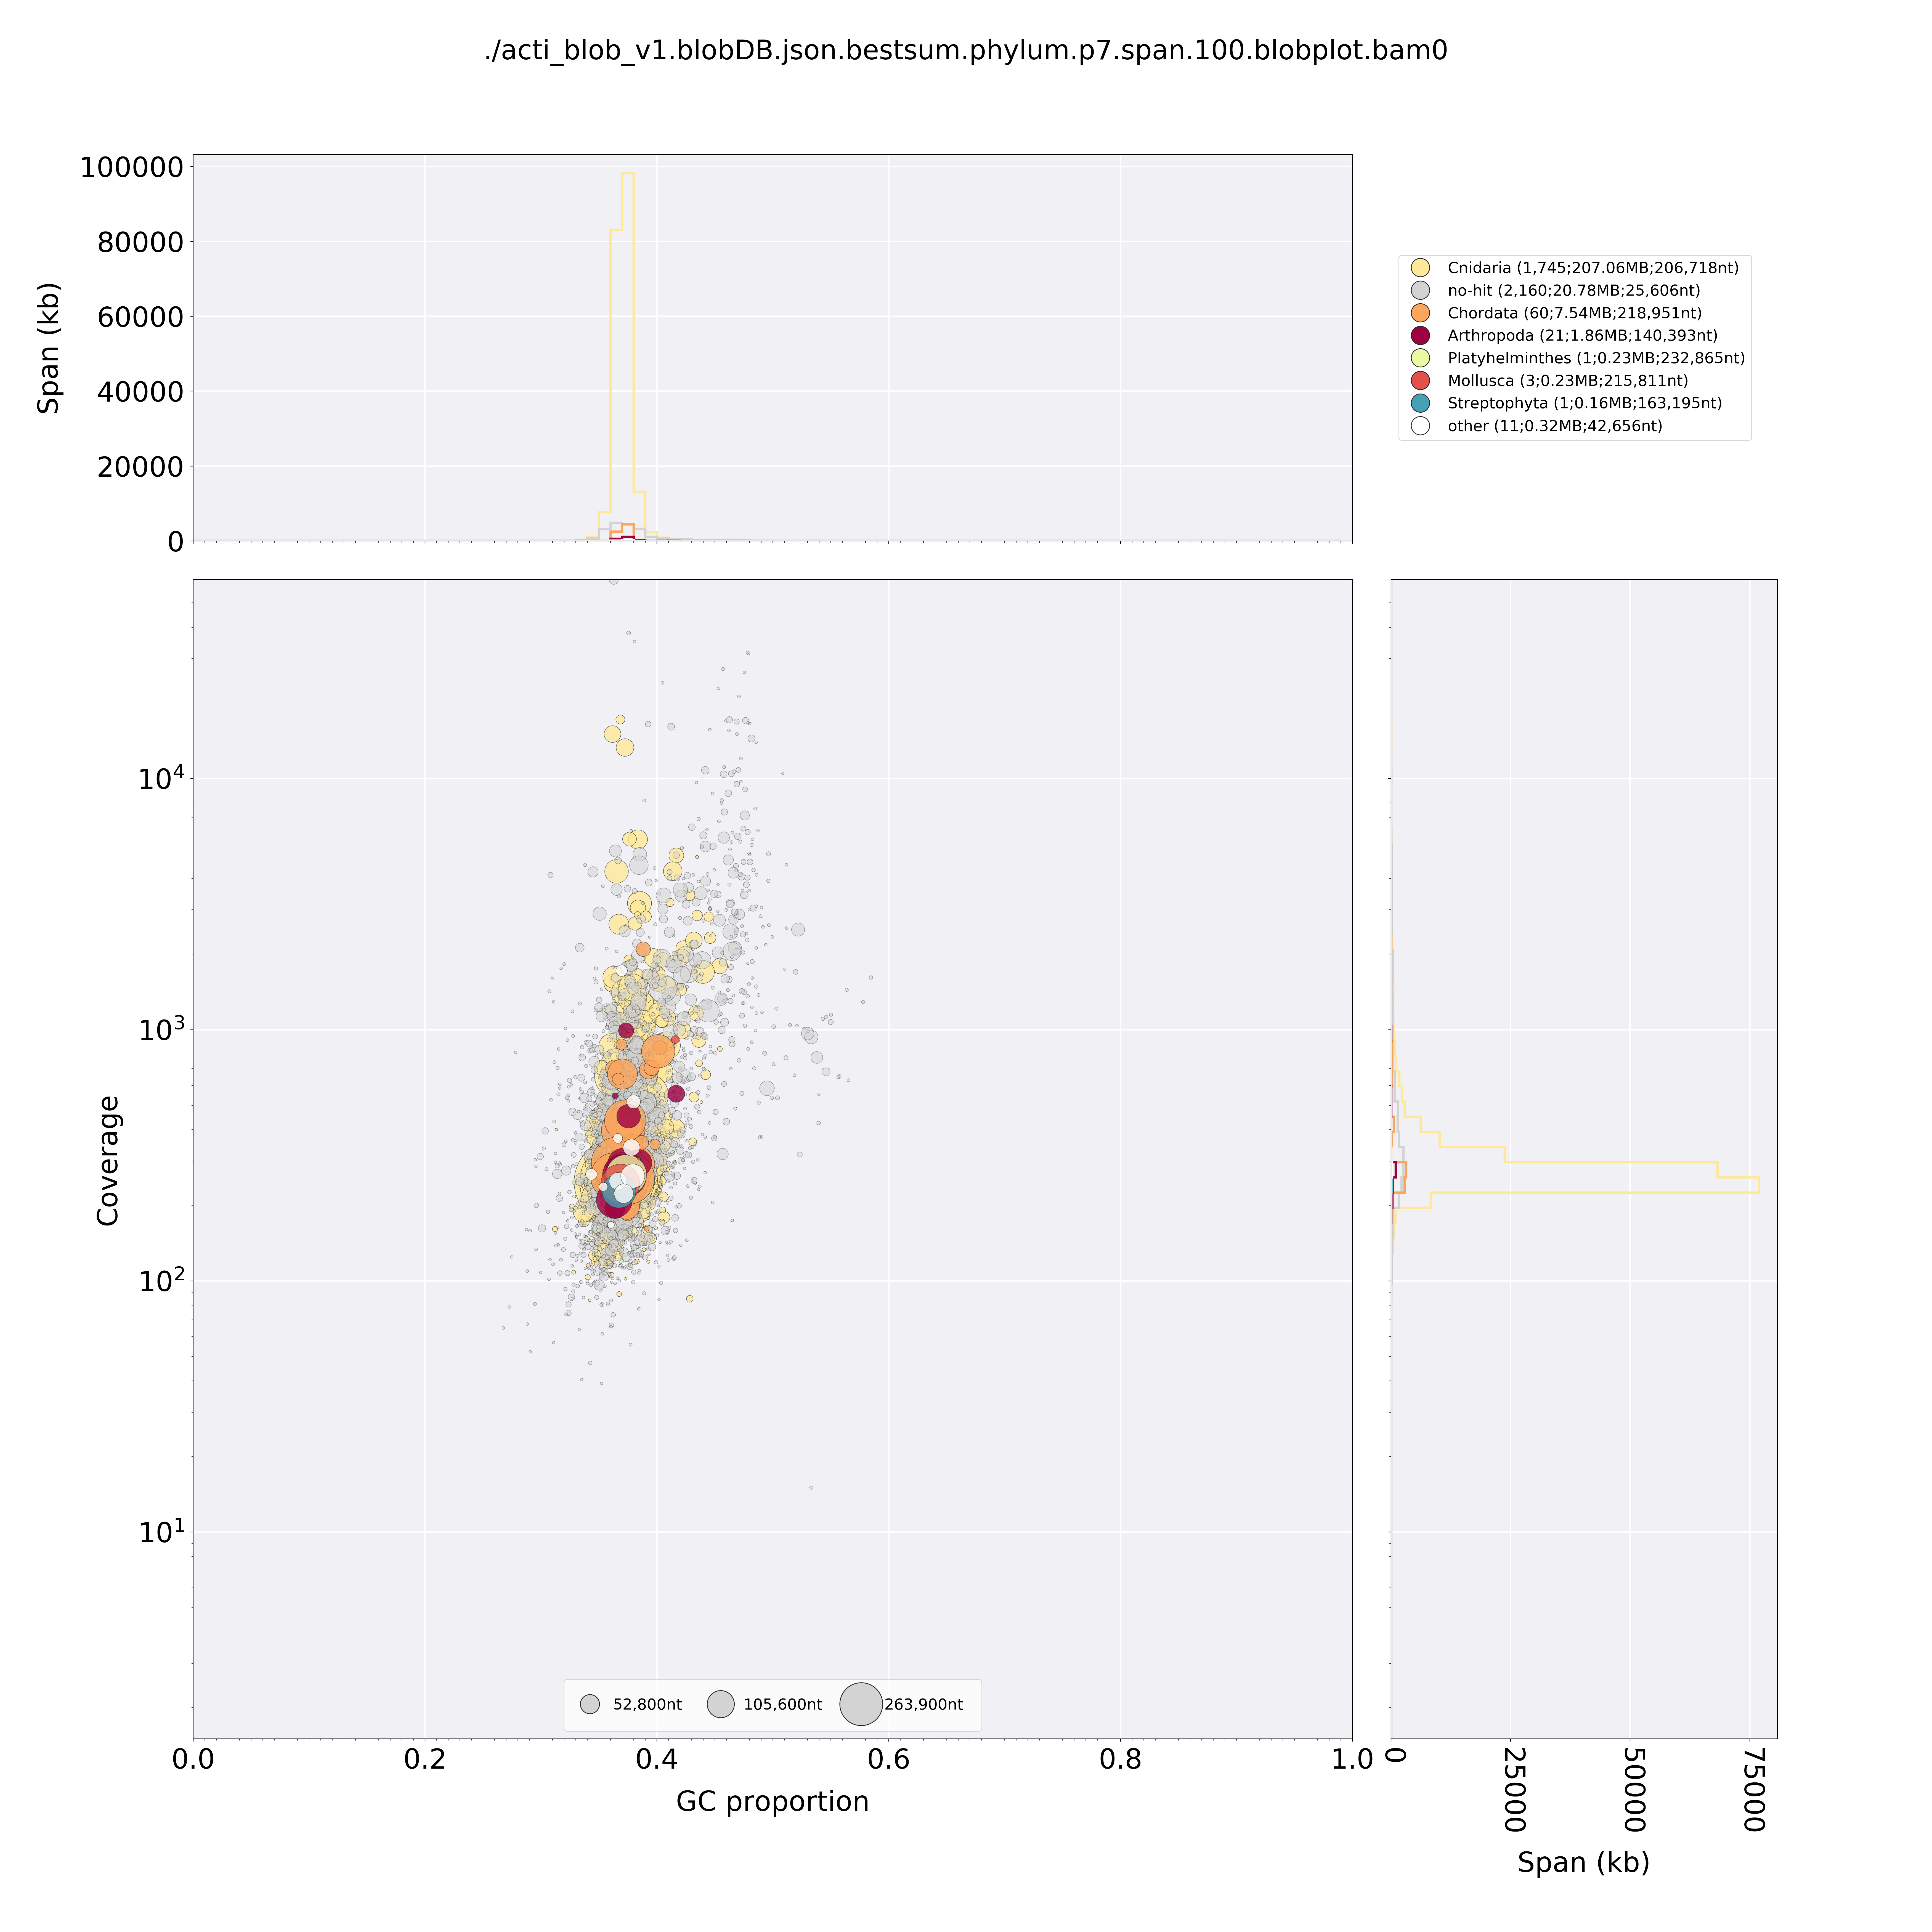

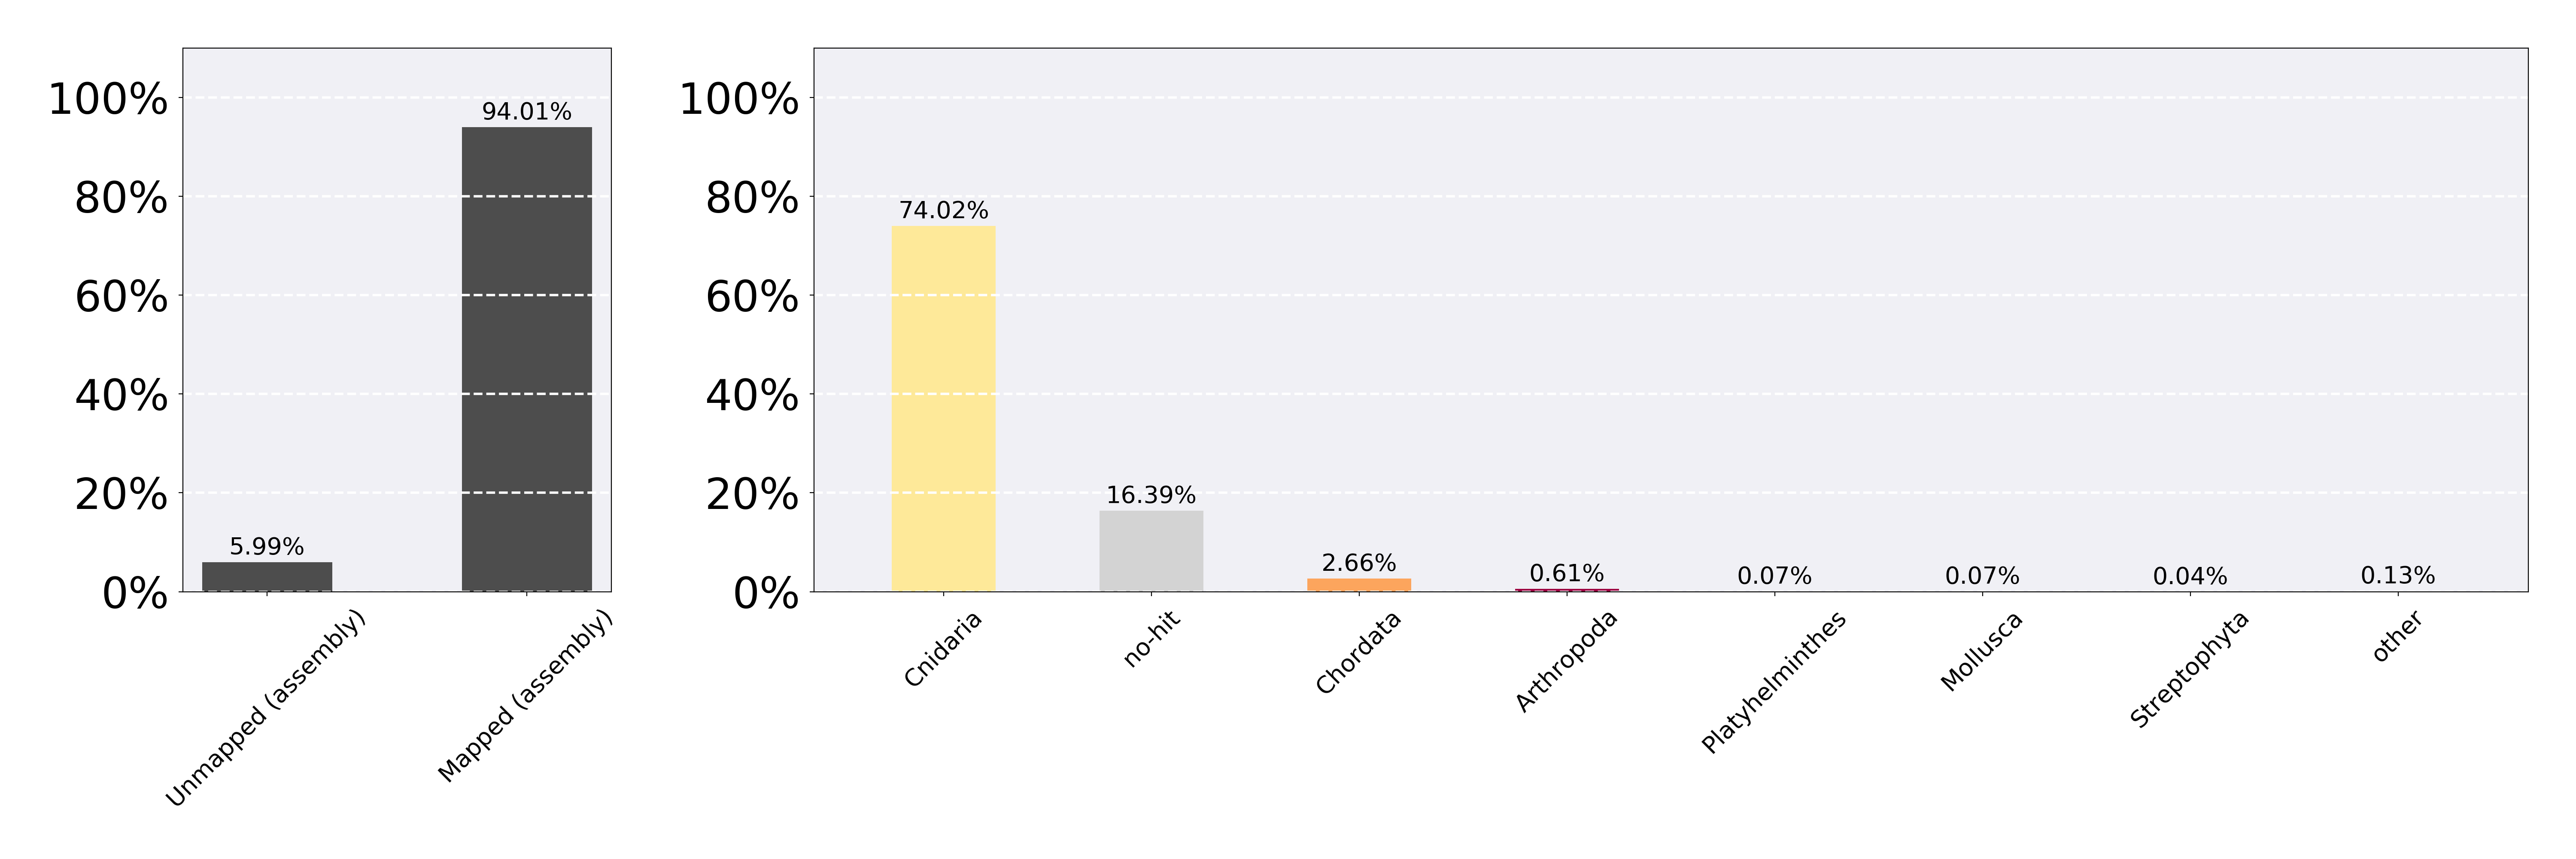

Ta da! It only took me like three weeks to get here! *sobs*  